# Hold-out

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import chi2_contingency


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')



In [46]:

from rapidfuzz import fuzz, process
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


In [47]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#ta errado, olhar para o nome do ficheiro
# test_price = pd.read_csv("sample_submission.csv")

In [48]:
#test_merge = pd.merge(test, test_price, on='carID', how='left')
#test_merge.head()

In [49]:
X_train_val = train.drop('price', axis=1) 
y_train_val = train['price']
X_test = test.copy()


In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val, 
    test_size=0.25, 
    random_state=15,
    shuffle=True
)

In [51]:
print('train:{}% | validation:{}%'.format(round(len(y_train)/len(y_train_val),2),
                                                     round(len(y_val)/len(y_train_val),2),))

train:0.75% | validation:0.25%


In [52]:
X_features = [X_train, X_val, X_test]

## Data Quality check

In [53]:
X_train.head(3)

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
11382,5314,AUDI,A1,2015.0,Manual,29119.0,Petrol,30.0,56.5,1.4,97.0,3.000000,0.0
50430,74187,VW,Golf,2016.0,Manua,20820.0,Petrol,200.0,39.8,2.0,62.0,1.000000,0.0
42482,19970,Ford,Focus,2019.0,Manual,1038.0,Petrol,145.0,50.4,1.5,77.0,-2.340306,0.0


In [54]:
X_train.duplicated("carID").sum()

np.int64(0)

No carID duplicated, so we can put as index.

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56979 entries, 11382 to 7624
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           56979 non-null  int64  
 1   Brand           55881 non-null  object 
 2   model           55833 non-null  object 
 3   year            55859 non-null  float64
 4   transmission    55831 non-null  object 
 5   mileage         55856 non-null  float64
 6   fuelType        55841 non-null  object 
 7   tax             51098 non-null  float64
 8   mpg             51079 non-null  float64
 9   engineSize      55833 non-null  float64
 10  paintQuality%   55812 non-null  float64
 11  previousOwners  55784 non-null  float64
 12  hasDamage       55842 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 6.1+ MB


In [56]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = X_train.columns.drop(metric_features).to_list()
non_metric_features.remove("carID")


We can conclude that we have many strange values in all columns and some Dtypes are wrong (year;previousOwners).

In [57]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,56979.0,38028.260324,21937.790672,0.000000,19037.5,38024.0,57011.5,75972.000000
year,55859.0,2017.099208,2.192280,1996.000000,2016.0,2017.0,2019.0,2024.121759
mileage,55856.0,22971.941864,22134.568422,-58540.574478,7449.5,17288.0,32380.0,323000.000000
tax,51098.0,119.921088,65.299578,-91.121630,125.0,145.0,145.0,580.000000
mpg,51079.0,55.164644,16.439379,-43.421768,46.3,54.3,62.8,470.800000
engineSize,55833.0,1.658536,0.570381,-0.103493,1.2,1.6,2.0,6.200000
paintQuality%,55812.0,64.626594,21.026829,1.638913,47.0,65.0,82.0,125.594308
previousOwners,55784.0,1.998415,1.473250,-2.345650,1.0,2.0,3.0,6.258371
hasDamage,55842.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


##### Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

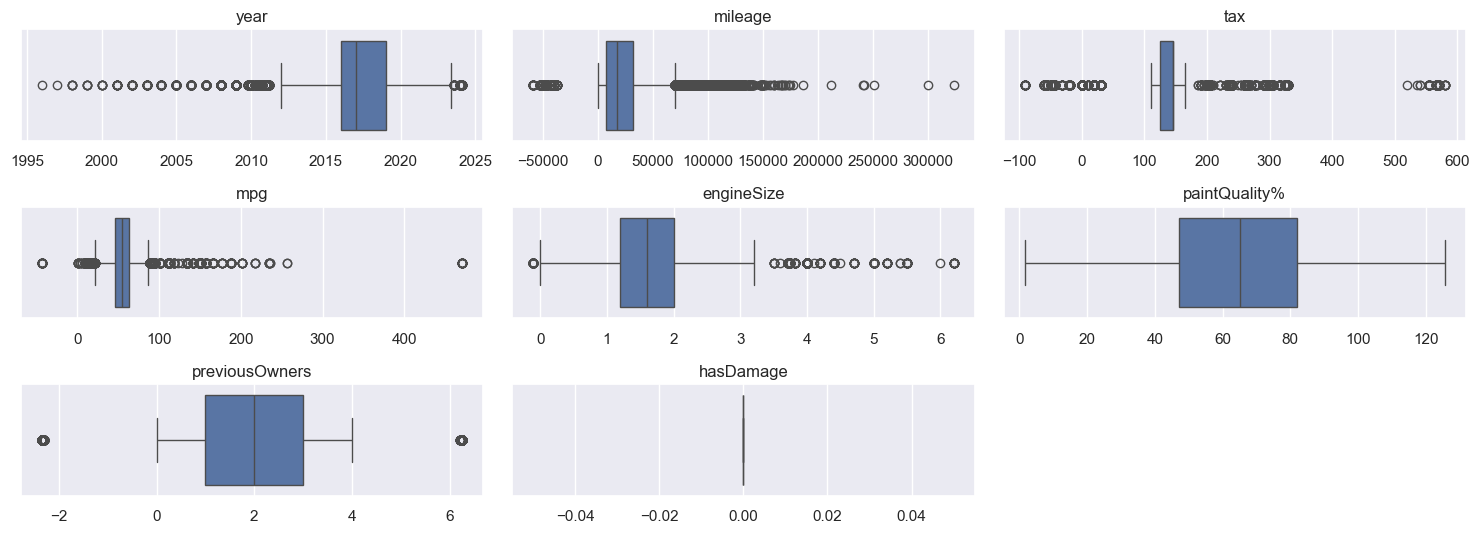

In [58]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=X_train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

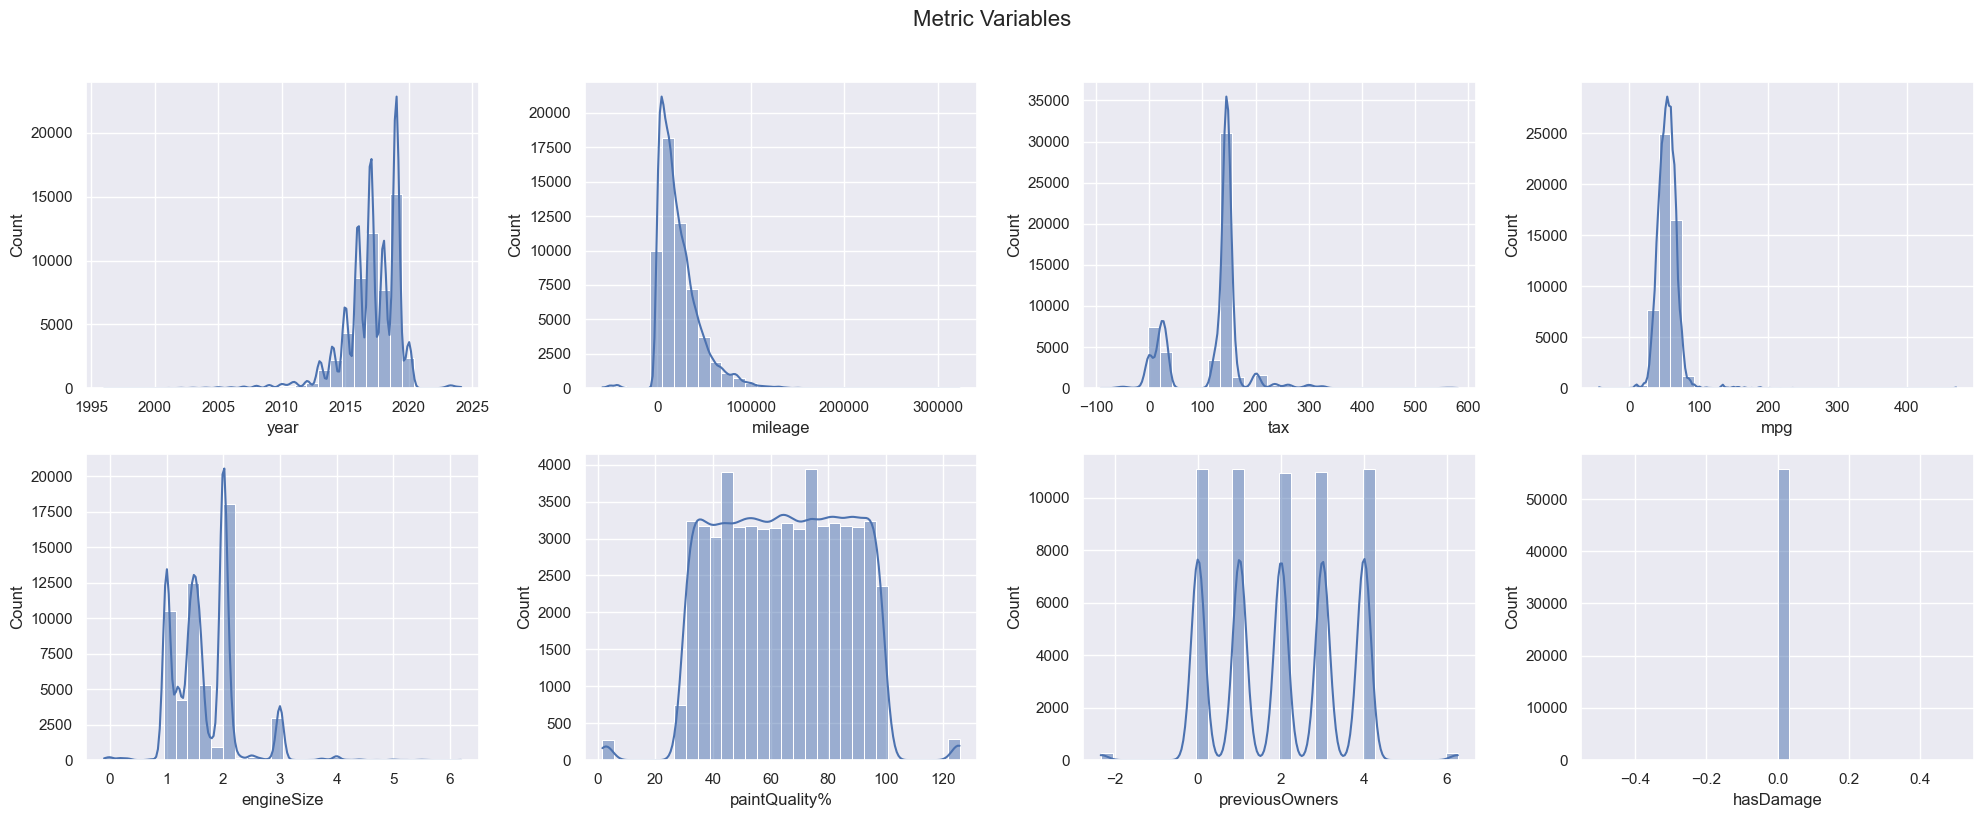

In [59]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(X_train[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()


From the histograms, I can observe that most of the metric variables are right-skewed and contain several outliers. Because of this non-normal distribution, replacing missing values (NaNs) with the median is more appropriate than using the mean, as the median is less affected by extreme values and better represents the central tendency of skewed data.

In [60]:
print(X_train.isna().sum())

carID                0
Brand             1098
model             1146
year              1120
transmission      1148
mileage           1123
fuelType          1138
tax               5881
mpg               5900
engineSize        1146
paintQuality%     1167
previousOwners    1195
hasDamage         1137
dtype: int64


In [61]:
X_train.hasDamage.value_counts()

hasDamage
0.0    55842
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all

# Pre Processing 

## Metric variables

In [62]:
def strange_values_to_nan(f,column,limit):
    strange_values = f[column] < limit
    f.loc[strange_values, column] = np.nan 
    print(f"Found {strange_values.sum()} strange values in {column}.")

In [63]:
def pre_processing_metric(metric):
    for f in metric:
        
        #setting carID as index
        f.set_index("carID", inplace=True)

        #fixing the types
        f["year"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in f["year"]]
        f["year"] = f["year"].astype("Int64")
        f["previousOwners"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in f["previousOwners"]]
        f["previousOwners"] = f["previousOwners"].astype("Int64")

        #converting strange values to nan
        strange_values_to_nan(f,"mileage",0)
        strange_values_to_nan(f,"tax",0)
        strange_values_to_nan(f,"mpg",10)
        strange_values_to_nan(f,"engineSize",1)
        strange_values_to_nan(f,"previousOwners",0)
        f.loc[f["paintQuality%"] > 100, "paintQuality%"] = np.nan 

        #deleting column hasDamage because it has the same value in all rows
        del f["hasDamage"]

        #filling nans with the median
        for var in metric_features:
            median = f[var].median()
            f[var] = f[var].fillna(median)

In [64]:
X_train_num = X_train[metric_features]

X_train_cat = X_train[non_metric_features]

X_val_num = X_val[metric_features]

X_val_cat = X_val[non_metric_features]


In [65]:
metric_features.remove("hasDamage") #removing hasDamage from metric_features list, because we deleted this column.

In [66]:
pre_processing_metric(X_features)

Found 286 strange values in mileage.
Found 282 strange values in tax.
Found 108 strange values in mpg.
Found 437 strange values in engineSize.
Found 278 strange values in previousOwners.
Found 83 strange values in mileage.
Found 96 strange values in tax.
Found 43 strange values in mpg.
Found 137 strange values in engineSize.
Found 93 strange values in previousOwners.
Found 170 strange values in mileage.
Found 161 strange values in tax.
Found 74 strange values in mpg.
Found 245 strange values in engineSize.
Found 168 strange values in previousOwners.


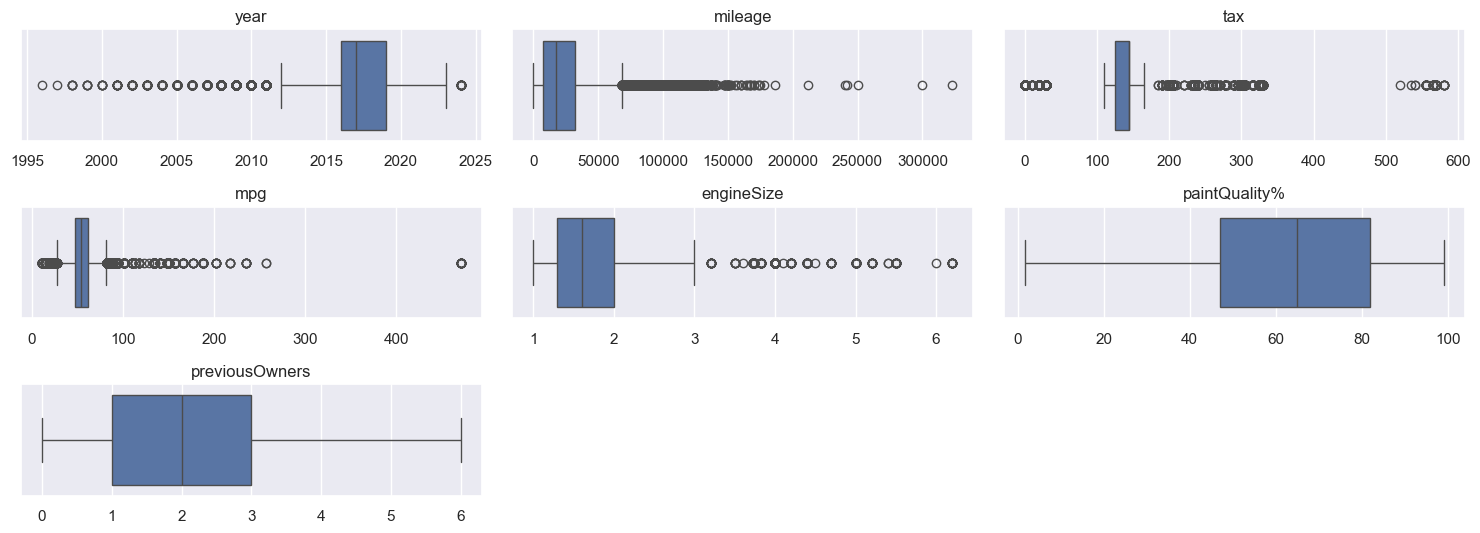

In [67]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=X_train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Scalling

In [68]:
#def scale_numeric_features(X_features, metric_features):

    #scaler = MinMaxScaler()

    # Fitting the scaler only on the train data
    #X_train = X_features[0].copy()
    #scaler.fit(X_train[metric_features])

    #scaled_features_list =[]

    #for i,X, in enumerate(X_features):
        #X_scaled = X.copy()
        #X_scaled[metric_features] = scaler.transform(X[metric_features])
        #scaled_features_list.append(X_scaled)

    #return scaled_features_list

#X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features, metric_features )

#X_train_num_scaled = X_train_scaled[metric_features]
#X_val_num_scaled = X_val_scaled[metric_features]

#print(X_train_num_scaled.min())
#print(X_train_num_scaled.max())

In [69]:
###PERGUNTAR OQ ACHAM, SE USARMOS ESTE O R DA LINEAR SVR FICA POSITIVO (0.5); usar o inputscaler() para preencher com a mediana
from sklearn.preprocessing import RobustScaler

def scale_numeric_features(X_features, metric_features):

    # TROQUE ESTA LINHA:
    # scaler = MinMaxScaler()
    scaler = RobustScaler() # <--- MUDANÇA AQUI

    # Fitting the scaler only on the train data
    X_train = X_features[0].copy()
    scaler.fit(X_train[metric_features])

    # ... o resto do seu código está PERFEITO e não muda ...
    
    scaled_features_list =[]

    for i,X, in enumerate(X_features):
        X_scaled = X.copy()
        X_scaled[metric_features] = scaler.transform(X[metric_features])
        scaled_features_list.append(X_scaled)

    return scaled_features_list
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features, metric_features )

X_train_num_scaled = X_train_scaled[metric_features]
X_val_num_scaled = X_val_scaled[metric_features]

print(X_train_num_scaled.min())
print(X_train_num_scaled.max())

year             -7.000000
mileage          -0.720810
tax              -7.250000
mpg              -3.176499
engineSize       -0.857143
paintQuality%    -1.810317
previousOwners   -1.000000
dtype: float64
year               2.333333
mileage           12.652782
tax               21.750000
mpg               30.851852
engineSize         6.571429
paintQuality%      0.971429
previousOwners     2.000000
dtype: float64


## Non metric variables


In [70]:
def build_valid_dic(column, valid_list, cuttoff):
    #first, clean de column and the valid list
    unique_column_values = [str(v).strip().lower() for v in column.dropna().unique()]
    #secound, creat the dic with the valid values with empyt similar words
    result = {valid_word: [] for valid_word in valid_list}

    for valid in valid_list:
        valid_lower = valid.lower()
        fuzzy_matched_values = process.extract(
            valid_lower, #the check valeu
            unique_column_values, #the list that we are going to use to check
            scorer = fuzz.token_sort_ratio,
            score_cutoff = cuttoff
        )
        for match_value, score, _ in fuzzy_matched_values:
            if match_value != valid_lower:
                result[valid].append(match_value)

    return result


def replace_invalid_values(column, valid_dic):
    corrected = []
    for val in column:
        if pd.isna(val):
            corrected.append(val)
            continue
        valeu_cleaned = str(val).strip().lower()
        found = False
        for key in valid_dic:
            if valeu_cleaned == key.lower():
                corrected.append(key)
                found = True
                break
        if not found:
            for valid_key, variations in valid_dic.items():
                if valeu_cleaned in [v.lower() for v in variations]:
                    corrected.append(valid_key)
                    found = True
                    break
        if not found:
            corrected.append(val)

    return corrected
def fill_nans_categorical(data, columns):
    for col in columns:
        data[col] =data[col].fillna("Unknown")
    return data


def dic_brand_modles(brands, models, valid_brands):
    result = {brand: [] for brand in valid_brands}
    for brand, model in zip(brands,models):
        if pd.isna(brand) or pd.isna(model):
            continue
        model_clean = str(model).strip().lower()
        if model_clean not in result[brand]:
            result[brand].append(model_clean)

    return result

def pre_processing_non_metric(dic_col_valid, data):
    for i in range(1,4):
        for key,values in dic_col_valid.items():
            valid_dic = build_valid_dic(data[key],values, cuttoff= 50)
            data[key] = replace_invalid_values(data[key], valid_dic)
            if i == 3:
                print(data[key].value_counts())
        

In [71]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota","Skoda", "Hyundai", "Unknown"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol" ,"Diesel", "Hybrid" , "Other", "Electric", "Unknown"]
cols_change_dic = {"Brand" : valid_brands_list,
                   "transmission" : valid_transmition_list,
                   "fuelType" : valid_fueltype_list
                   }

In [72]:
###NOS QUEREMOS TRABALHAR JA COM OS SCALED
X_features=[X_train_scaled,X_test_scaled,X_val_scaled]
for f in X_features:
    fill_nans_categorical(f, non_metric_features)
    pre_processing_non_metric(cols_change_dic, f)

Brand
Ford        12032
Mercedes     8744
VW           7836
Opel         6978
BMW          5520
Audi         5494
Toyota       3499
Skoda        3271
Hyundai      2507
Unknown      1098
Name: count, dtype: int64
transmission
Manual       31165
Semi-Auto    12683
Automatic    11441
Unknown       1687
Other            3
Name: count, dtype: int64
fuelType
Petrol      30879
Diesel      23132
Hybrid       1689
Unknown      1138
Other         124
Electric       17
Name: count, dtype: int64
Brand
Ford        6891
Mercedes    5004
VW          4466
Opel        4008
BMW         3174
Audi        3130
Toyota      1982
Skoda       1836
Hyundai     1427
Unknown      649
Name: count, dtype: int64
transmission
Manual       17889
Semi-Auto     7267
Automatic     6440
Unknown        968
Other            3
Name: count, dtype: int64
fuelType
Petrol      17488
Diesel      13395
Hybrid        936
Unknown       656
Other          82
Electric       10
Name: count, dtype: int64
Brand
Ford        4033
Mercedes 

In [73]:
### pus X_test_scaled_ em vez X_test
dic_brands = dic_brand_modles(X_test_scaled["Brand"],X_test_scaled["model"],valid_brands_list)
for key, value in dic_brands.items():
    print(f"{key} have this models:\n {value}")

Ford have this models:
 ['fiesta', 'focus', 'ecosport', 'kuga', 'grand c-max', 'ka+', 'unknown', 'ka', 'focu', 'galaxy', 'mondeo', 'fiest', 'c-max', 'fusion', 'b-max', 'puma', 's-max', 'edge', 'tourneo custom', 'mustang', 'b-ma', 'monde', 's-ma', 'kug', 'ecospor', 'grand tourneo connect', 'octavi', 'tourneo custo', 'tourneo connect', 'edg', 'fabia', 'c-ma', 'galax', 'kodia', 'grand tourneo connec', 'transit tourneo', 'grand c-ma', 'pum', 'k']
Mercedes have this models:
 ['b class', 'c class', 'm clas', 'e class', 'a class', 'x-class', 'v class', 'sl class', 'gla class', 'cls class', 'glc class', 'cl class', 's class', 'c clas', 'gl class', 'gle class', 'unknown', 'cla class', 'g clas', 'slk', 'm class', 'glb class', 'gls class', 'cl clas', 'e clas', 'x-clas', '180', 'glc clas', 'g class', 'a clas', 'r class', 'b clas', 'gla clas', 'sl clas', 'clk', 'clc class', 's clas', 'cla clas', 'gl clas', 'sl', 'gls clas']
VW have this models:
 ['tiguan', 'up', 'golf', 'passat', 'caravelle', 'polo

# Feature Selection

In [74]:
X_train_num_scaled[metric_features].var()

year              0.524488
mileage           0.782107
tax               9.350035
mpg               1.288926
engineSize        0.614973
paintQuality%     0.338558
previousOwners    0.505834
dtype: float64

### Spearman Correlation

In [75]:
cor_spearman = X_train_num_scaled.corr(method ='spearman')
cor_spearman

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
year,1.000000,-0.770101,0.306730,-0.298245,-0.038628,0.004206,0.006404
mileage,-0.770101,1.000000,-0.248422,0.309940,0.100115,-0.002435,-0.000336
tax,0.306730,-0.248422,1.000000,-0.539544,0.143652,0.002433,0.001280
mpg,-0.298245,0.309940,-0.539544,1.000000,-0.181158,0.001349,-0.001205
engineSize,-0.038628,0.100115,0.143652,-0.181158,1.000000,0.003107,0.006320
paintQuality%,0.004206,-0.002435,0.002433,0.001349,0.003107,1.000000,-0.007056
previousOwners,0.006404,-0.000336,0.001280,-0.001205,0.006320,-0.007056,1.000000


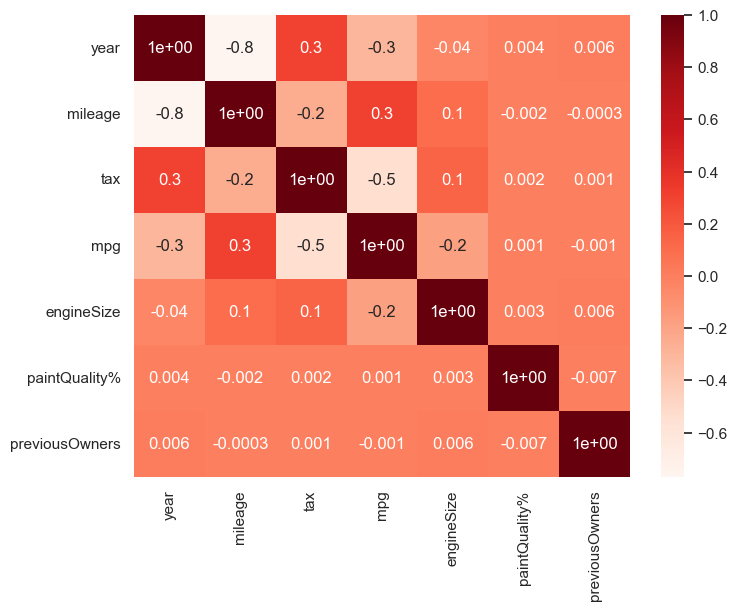

In [76]:
def cor_heatmap(cor):
    plt.figure(figsize=(8,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor_heatmap (cor_spearman)

### Chi2

In [77]:
def testindependence1(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [78]:
for var in X_train_cat:
    testindependence1(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is NOT an important predictor. (Discard fuelType from model)


### Linear Regression

In [79]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    #call support vector machines classifier
    model = LinearRegression()
    
    #create RFE instance
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    #fit and transform for training data, transform for val data
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score > high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 4
Score with 4 features: 0.666347
Features to select: 
year               True
mileage            True
tax               False
mpg                True
engineSize         True
paintQuality%     False
previousOwners    False
dtype: bool


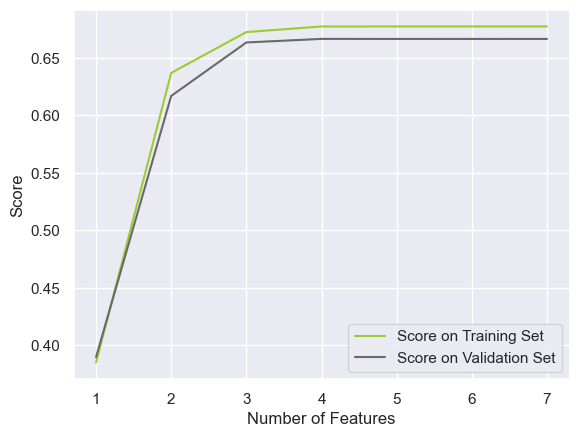

In [80]:
plt.plot(list(range(1,8)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,8)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lasso Regression 

Lasso picked 6 variables and eliminated the other 1 variables
mileage          -2650.348000
mpg               -615.680520
paintQuality%      -67.806502
tax                 -4.592722
previousOwners       0.000000
year              4363.676574
engineSize        7906.694375
dtype: float64


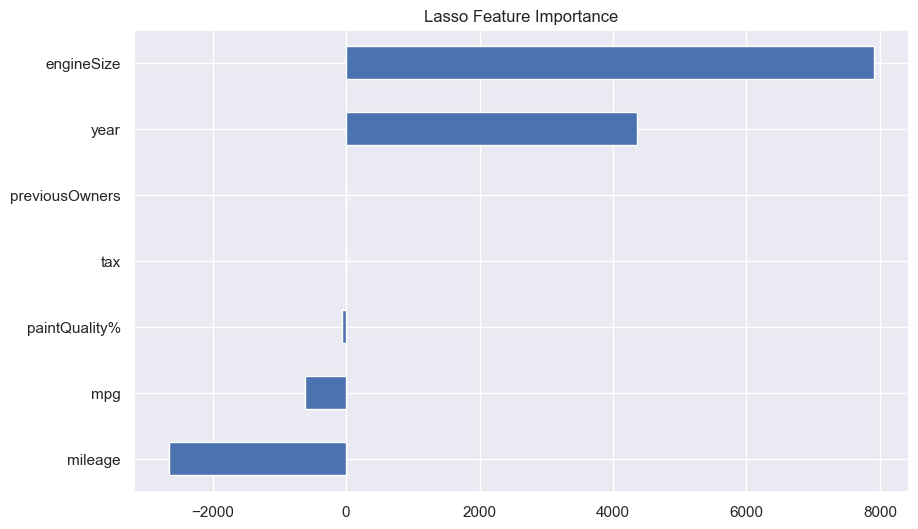

In [81]:
from sklearn.linear_model import LassoCV

# Função para plotar importância das features
def plot_importance(coef, title):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(10,6))
    imp_coef.plot(kind="barh")
    plt.title(title)
    plt.show()

# Separar as features numéricas escaladas
numeric_cols = metric_features  # as que escalaste
X_train_num_scaled = X_train_scaled[numeric_cols]

# LassoCV
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train_num_scaled, y_train)

# Coeficientes
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")
print(coef.sort_values())

# Plot
plot_importance(coef, "Lasso Feature Importance")

### Results and conclusions

<font color=#00A36C>Numerical Features</font>

| Predictor       | Spearman | RFE Linear | Lasso  | What to do? |
|-----------------|----------|------------|--------|-------------|
| year            | Keep     | Keep       | Keep   | Include in the model |
| mileage         | Keep     | Keep       | Keep   | Include in the model |
| tax             | Keep     | Discard    | Discard| Discard |
| mpg             | Keep     | Keep       | Keep   | Include in the model |
| engineSize      | Keep     | Keep       | Keep   | Include in the model |
| paintQuality%   | Keep     | Discard    | Keep   | ? |
| previousOwners  | Keep     | Discard    | Keep   | Discard |

 <font color=#00A36C>Categorical Features</font>

| Predictor       | Chi-Square Result                | What do |
|-----------------|----------------------------------| -- |
| Brand           | Keep                             | Include in the model |
| model           | Keep                             | Include in the model |
| transmission    | Keep                             | Include in the model |
| fuelType        | Discard                          | Discard |

In [82]:
def remove_columns(dfs):
    columns_to_remove=["tax","paintQuality%","previousOwners","fuelType"]
    for X in dfs:
        X=X.drop(columns_to_remove, axis=1, inplace=True)
    return dfs

In [83]:
remove_columns(X_features)
non_metric_features.remove("fuelType")

# Encoding

In [84]:
def encode_non_metric_features_manual(data, non_metric_features):
    mappings = {}

    for col in non_metric_features:   
        # get unique values and create mapping
        unique_values = data[col].dropna().unique()
        value_to_int = {val: idx for idx, val in enumerate(unique_values)}
        
        # map the column
        data[col] = data[col].map(value_to_int)
        
        # store mapping
        mappings[col] = value_to_int

    # print mappings for each newly encoded column
    for col, mapping in mappings.items():
        print(f"{col}:")
        print(mapping)
        print()

In [85]:
for f in X_features:
    encode_non_metric_features_manual(f, non_metric_features)

Brand:
{'Audi': 0, 'VW': 1, 'Ford': 2, 'Opel': 3, 'Mercedes': 4, 'BMW': 5, 'Skoda': 6, 'Toyota': 7, 'Hyundai': 8, 'Unknown': 9}

model:
{' A1': 0, ' Golf': 1, 'Focus': 2, ' Passat': 3, ' Corsa': 4, ' A4': 5, ' EcoSport': 6, ' A Class': 7, ' T-Roc': 8, ' Focus': 9, ' Amarok': 10, ' Mondeo': 11, ' Polo': 12, ' C Class': 13, 'Unknown': 14, ' 1 Series': 15, ' Fiesta': 16, ' Yeti': 17, ' Yaris': 18, ' I10': 19, ' Ioniq': 20, ' Adam': 21, ' Auris': 22, ' Tiguan': 23, ' A3': 24, ' 4 Series': 25, ' C-MAX': 26, ' Grandland X': 27, ' 5 Series': 28, ' A6': 29, ' Octavia': 30, ' 3 Series': 31, ' E Class': 32, ' CLS Class': 33, ' Edge': 34, ' Kuga': 35, ' 2 Series': 36, ' OCTAVIA': 37, ' Meriva': 38, ' corsa': 39, ' astra': 40, ' ECOSPORT': 41, ' touareg': 42, ' Fabia': 43, ' Q3': 44, ' M Clas': 45, ' YETI OUTDOOR': 46, 'RAV4': 47, ' Q2': 48, ' Cors': 49, ' ASTRA': 50, ' Up': 51, ' Mustang': 52, ' Tucson': 53, ' S-MAX': 54, ' Touran': 55, ' 3 SERIES': 56, ' X3': 57, ' a1': 58, ' A5': 59, ' I30': 60

### Model Evaluation

In [86]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=42), 
    "Ridge": Ridge(alpha=0.1, random_state=42),
    "Linear SVR": LinearSVR(random_state=42, max_iter=3000, dual="auto"), 
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10) 
}
results = {}

In [87]:
for name, model in models.items():
    #training the model
    model.fit(X_train_scaled, y_train)

    #predicting with test data
    y_pred_val=model.predict(X_val_scaled)
    
    #metrics
    r2 = r2_score(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    results[name] = {"R²": r2, "MAE": mae, "RMSE": rmse}
    print(f"\nResults for: {name}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")


Results for: Linear Regression
  R²:   0.6402
  MAE:  4093.14
  RMSE: 6020.20

Results for: Lasso
  R²:   0.6402
  MAE:  4093.12
  RMSE: 6020.20

Results for: Ridge
  R²:   0.6402
  MAE:  4093.14
  RMSE: 6020.20

Results for: Linear SVR
  R²:   0.4842
  MAE:  4648.26
  RMSE: 7208.00

Results for: Random Forest
  R²:   0.5014
  MAE:  4683.98
  RMSE: 7086.51


### Hyperparameter tuning with GridSearchCV

In [88]:
import numpy as np
from sklearn.model_selection import GridSearchCV

# Importe todos os seus modelos
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# --- 1. Definição dos Modelos e Grelhas de Parâmetros ---

# Lista de tuplos: (Nome, Modelo, Grelha de Parâmetros)
models_to_tune = [
    (
        "Lasso",
        Lasso(random_state=42),
        {
            # Testa 10 valores de alpha entre 0.1 e 10.0
            'alpha': np.linspace(0.1, 10.0, 10)
        }
    ),
    (
        "Ridge",
        Ridge(random_state=42),
        {
            # Testa 10 valores de alpha entre 0.1 e 10.0
            'alpha': np.linspace(0.1, 10.0, 10)
        }
    ),
    (
        "Linear SVR",
        LinearSVR(random_state=42, max_iter=5000, dual="auto"), # Aumentei max_iter
        {
            # Testa 5 valores para C (regularização)
            'C': np.linspace(0.1, 10.0, 5),
            # Testa 3 valores para epsilon (margem de erro)
            'epsilon': np.linspace(0.05, 0.5, 3)
        }
    ),
    #(
        #"Random Forest",
        #RandomForestRegressor(random_state=42, n_jobs=-1),
        #{
            #'max_depth': [8, 10, 12, 15, 18],
            #'n_estimators': [100, 200],
            #'min_samples_split': [10, 20, 40],
            #'min_samples_leaf': [5, 10, 15],
            #'max_features': ['sqrt', 0.5, 0.7]

        #}
    #)
]

# --- 2. Execução do Loop de Tuning ---

# Vamos guardar os melhores resultados aqui
best_models_results = []

print("--- Iniciando o Hyperparameter Tuning ---")

for name, model, param_grid in models_to_tune:
    
    print(f"\n... A otimizar o modelo: {name} ...")
    
    # Configurar o GridSearchCV
    # cv=5 (Cross-Validation de 5 folds) é um bom padrão
    # scoring='r2' otimiza para o melhor R²
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1, # Usa todos os processadores
        verbose=1  # Mostra algum output
    )
    
    # Treinar o GridSearch (isto pode demorar algum tempo!)
    # Ele usa os dados de treino e faz a validação cruzada internamente
    grid_search.fit(X_train_scaled, y_train)
    
    # Guardar os resultados
    best_models_results.append({
        'name': name,
        'best_score_r2': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_ # O melhor modelo já treinado
    })
    
    print(f"Resultados para {name}:")
    print(f"  Melhor R² (CV): {grid_search.best_score_:.4f}")
    print(f"  Melhores Parâmetros: {grid_search.best_params_}")

print("\n--- Tuning Concluído ---")

# --- 3. Sumário dos Resultados do Tuning ---

# Ordenar os resultados pelo melhor R²
best_models_results_sorted = sorted(best_models_results, key=lambda x: x['best_score_r2'], reverse=True)

print("\n--- Sumário dos Melhores Modelos (baseado no R² da Validação Cruzada) ---")
for result in best_models_results_sorted:
    print(f"Modelo: {result['name']}")
    print(f"  R² (CV): {result['best_score_r2']:.4f}")
    print(f"  Parâmetros: {result['best_params']}\n")

# --- 4. AVALIAÇÃO FINAL NO CONJUNTO DE Val ---


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Pegar no melhor modelo de todos
best_overall_model = best_models_results_sorted[0]['best_estimator']
best_overall_name = best_models_results_sorted[0]['name']

print(f"\n--- Avaliação Final do Melhor Modelo ({best_overall_name}) no Conjunto VAL ---")

# Usar o conjunto de TESTE (X_test_scaled, y_test)
y_pred_val = best_overall_model.predict(X_val_scaled)

# Calcular métricas finais
r2_final = r2_score(y_val, y_pred_val)
mae_final = mean_absolute_error(y_val, y_pred_val)
rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"R² Final: {r2_final:.4f}")
print(f"MAE Final: {mae_final:.2f}")
print(f"RMSE Final: {rmse_final:.2f}")

--- Iniciando o Hyperparameter Tuning ---

... A otimizar o modelo: Lasso ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Resultados para Lasso:
  Melhor R² (CV): 0.6988
  Melhores Parâmetros: {'alpha': np.float64(2.3000000000000003)}

... A otimizar o modelo: Ridge ...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Resultados para Ridge:
  Melhor R² (CV): 0.6988
  Melhores Parâmetros: {'alpha': np.float64(10.0)}

... A otimizar o modelo: Linear SVR ...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


KeyboardInterrupt: 